In [238]:
# Necessary libraries for analysis
#=================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import miceforest as mf
import scipy.stats as stats
import statsmodels.api as sm   


from sklearn import cluster, metrics
from sklearn.preprocessing import OrdinalEncoder, StandardScaler


# Warnings settings
#=================================================================
import warnings
warnings.filterwarnings("ignore") 



In [239]:
# Fijar semilla de numpy
np.random.seed(0)

### Importar datos

In [240]:
# Importar datos

dataset = pd.read_csv(r"Employees.csv")
dataset.head(3)


,Employee_ID,Gender,Age,Education_Level,Relationship_Status,Hometown,Unit,Decision_skill_possess,Time_of_service,Time_since_promotion,growth_rate,Travel_Rate,Post_Level,Pay_Scale,Compensation_and_Benefits,Work_Life_balance,Attrition_rate
0,EID_23371,F,42.0,4,Married,Franklin,IT,Conceptual,4.0,4,33,1,1,7.0,type2,3.0,0.1841
1,EID_18000,M,24.0,3,Single,Springfield,Logistics,Analytical,5.0,4,36,0,3,6.0,type2,4.0,0.0670
2,EID_3891,F,58.0,3,Married,Clinton,Quality,Conceptual,27.0,3,51,0,2,8.0,type2,1.0,0.0851


In [241]:
# Crear una copia del set de datos original

data = dataset.copy()

### Análisis exploratorio de datos

In [242]:
# Dimensión de los datos

data_dim = data.shape
print("El set de datos a trabajar tiene un tamaño", data_dim,
    "\n")


El set de datos a trabajar tiene un tamaño (7000, 17) 



In [243]:
# Tipos de variables y número de variables por tipo

variable_types = pd.DataFrame(data.dtypes.value_counts())
variable_types.set_axis(['Variables'],axis=1,inplace=True)
print("Los tipos de variables con los que se cuenta son 'object', 'float64' e 'int64', es decir, se cuenta",
    "con variables del tipo numérico (continuas y discretas) y de variables de texto.")
variable_types



Los tipos de variables con los que se cuenta son 'object', 'float64' e 'int64', es decir, se cuenta con variables del tipo numérico (continuas y discretas) y de variables de texto.


,Variables
object,7
float64,5
int64,5


In [244]:
# Detectar columnas con valores perdidos y número de valores perdidos por columna

data_types = pd.DataFrame(data.dtypes) # Crea un datafaframe de las variables y su tipo
data_missing_values = pd.DataFrame(data.isna().sum()) # Crea un dataframe con valores perdidos por variable
data_missing_variables = pd.concat([data_missing_values,data_types],axis=1) # Concatena valores perdidos con tipo de variable por variable
data_missing_variables.set_axis(['Missing values','Data type'],axis=1,inplace=True) # Set col names n = numero de valores perdidos, type = tipo de datos
data_missing_variables = data_missing_variables[data_missing_variables['Missing values'] != 0] # Filtrar variables para obtener campos con datos perdidos ()
missing_variabes = data_missing_variables.index

print("Existen",data_missing_variables.shape[0],"campos o variables con valores fatantes, las cuáles se muestran en la siguiente tabla:")
print("\n",data_missing_variables,"\n\nSe observa que todas las variables que presentan valores perdidos son del tipo numérico, dos orinales y dos contínuas")

Existen 4 campos o variables con valores fatantes, las cuáles se muestran en la siguiente tabla:

                    Missing values Data type
Age                           412   float64
Time_of_service               144   float64
Pay_Scale                       9   float64
Work_Life_balance              11   float64 

Se observa que todas las variables que presentan valores perdidos son del tipo numérico, dos orinales y dos contínuas


### Tratamiento de datos perdidos

In [245]:
# Comentarios

print("Las valores faltantes de las variables tipo numérica contínuas se han de imputar utilizando una técnica de imputación múltiple y los datos faltantes de variables numéricas disctretas se imputarán utilizando la moda, ya que este es el método generalmente aceptado y más utilizado para este tipo de datos.")

Las valores faltantes de las variables tipo numérica contínuas se han de imputar utilizando una técnica de imputación múltiple y los datos faltantes de variables numéricas disctretas se imputarán utilizando la moda, ya que este es el método generalmente aceptado y más utilizado para este tipo de datos.


In [246]:
# Imputación múltiple para datos contínuos
# Select dataset
df_num_mice = data[['Age','Time_of_service']]

# Create kernel. 
kernel = mf.ImputationKernel(
  df_num_mice,
  datasets=4,
  save_all_iterations=True,
  random_state=1
)

# Run the MICE algorithm for 2 iterations on each of the datasets
kernel.mice(2)

# Distribution of imputed values 
#kernel.plot_imputed_distributions(wspace=0.3,hspace=0.3)

# Printing the kernel will show you some high level information.
#print(kernel)

# Select dataset with imputated data
df_num_mice = kernel.complete_data(0)
df_num = df_num_mice

print("Se han imputado valores faltantes de las variables 'Time_of_service' y 'Age' \n \n Conteo de valores faltantes:",)
df_num.isna().sum()

Se han imputado valores faltantes de las variables 'Time_of_service' y 'Age' 
 
 Conteo de valores faltantes:


Age                0
Time_of_service    0
dtype: int64

In [247]:
# Agregar datos imputados al dataframe de trabajo

data['Age'] = df_num['Age']
data['Time_of_service'] = df_num['Time_of_service']

In [248]:
# Imputación de datos faltantes utilizando la moda

data['Pay_Scale'].fillna(data['Pay_Scale'].mode()[0], inplace=True)
data['Work_Life_balance'].fillna(data['Work_Life_balance'].mode()[0], inplace=True)

print("Se han imputado valores faltantes de las variables 'Pay_Scale' y 'Work_Life_balance' \n \n Conteo de valores faltantes:")
data[['Pay_Scale','Work_Life_balance']].isna().sum()

Se han imputado valores faltantes de las variables 'Pay_Scale' y 'Work_Life_balance' 
 
 Conteo de valores faltantes:


Pay_Scale            0
Work_Life_balance    0
dtype: int64

### Selección de campos para el análisis

In [250]:
# Eliminación de columnas 

print("No se tomará en cuenta la columna 'Employee_ID' puesto que esta es una etiqueta para cada registro y se elimina del set de datos")
data.drop(['Employee_ID'],axis=1,inplace=True)


No se tomará en cuenta la columna 'Employee_ID' puesto que esta es una etiqueta para cada registro y se elimina del set de datos


### Codificación de datos categóricos

In [251]:
# Transformar datos categóricos a numéricos utilizando Ordinal Encoder

print("Las variables categóricas del tipo 'object' se transforman a variables numéricas utilizando Ordinal Encoder y el set de datos resultante se convertirá en una matríz numérica de Numpy obteniendo: \n")
df = data.copy()
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = OrdinalEncoder().fit_transform(df[[col]])

X_train = df.to_numpy() # Convertir datos a una matríz numérica de numpy
print(X_train)

Las variables categóricas del tipo 'object' se transforman a variables numéricas utilizando Ordinal Encoder y el set de datos resultante se convertirá en una matríz numérica de Numpy obteniendo: 

[[ 0.     42.      4.     ...  2.      3.      0.1841]
 [ 1.     24.      3.     ...  2.      4.      0.067 ]
 [ 0.     58.      3.     ...  2.      1.      0.0851]
 ...
 [ 0.     49.      3.     ...  2.      4.      0.7847]
 [ 0.     47.      3.     ...  0.      2.      0.4162]
 [ 0.     58.      3.     ...  2.      3.      0.091 ]]


### Normalización de los datos

In [252]:
# Normalización de los datos

print("Los valores de la matriz de datos se normalizan para evitar la influencia de la escala de los valres en los resultados del análisis, obteniendo la siguiente matriz: \n")
X = StandardScaler().fit_transform(X_train)
X

Los valores de la matriz de datos se normalizan para evitar la influencia de la escala de los valres en los resultados del análisis, obteniendo la siguiente matriz: 



array([[-0.83756018,  0.17329973,  0.76255659, ..., -0.50555935,
         0.54692154, -0.02840599],
       [ 1.19394406, -1.15080223, -0.17638732, ..., -0.50555935,
         1.43725894, -0.65885713],
       [-0.83756018,  1.35027924, -0.17638732, ..., -0.50555935,
        -1.23375325, -0.56140908],
       ...,
       [-0.83756018,  0.68822826, -0.17638732, ..., -0.50555935,
         1.43725894,  3.20514613],
       [-0.83756018,  0.54110582, -0.17638732, ..., -3.24784175,
        -0.34341585,  1.22119016],
       [-0.83756018,  1.35027924, -0.17638732, ..., -0.50555935,
         0.54692154, -0.52964425]])

### K Means clustering

#### Evaluación del número de grupos mediante K Elbow plot

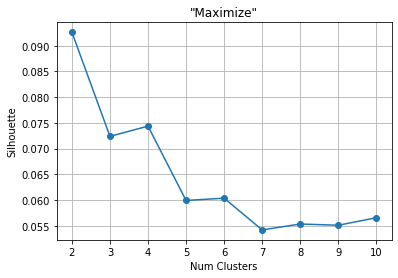

In [253]:
# Gráfica de K Elbow utilizando el índice Silohuette

nc = 11
results = {}

for k in range(2, nc):
    k_means = cluster.KMeans(n_clusters=k).fit(X)
    y_pred = k_means.predict(X)
    results[k] = metrics.silhouette_score(X, y_pred)


clusters_counts = list(results.keys())
index_values = list(results.values())
plt.plot(clusters_counts, index_values, 'o-')
plt.grid(True)
plt.title('"Maximize"')
plt.xlabel('Num Clusters')
plt.xticks(clusters_counts)
plt.ylabel('Silhouette')
plt.show()

#### Evaluación del número de grupos con el criterio de relación de varianzas

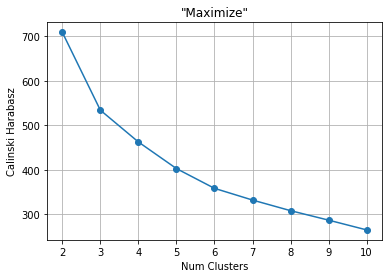

In [254]:
# Gráfica de K Elbow utilizando el índice Calinski Harabasz

nc = 11
results = {}

for k in range(2, nc):
    k_means = cluster.KMeans(n_clusters=k).fit(X)
    y_pred = k_means.predict(X)
    results[k] = metrics.calinski_harabasz_score(X, y_pred)

clusters_counts = list(results.keys())
index_values = list(results.values())

plt.plot(clusters_counts, index_values, 'o-')
plt.grid(True)
plt.title('"Maximize"')
plt.xlabel('Num Clusters')
plt.xticks(clusters_counts)
plt.ylabel('Calinski Harabasz')
plt.show()

In [255]:
# Creación de variable de pertenecia
k = 4

print("El número de grupos a clusters a calcular es",k,"La gráfica de K--Elbow utilizando el índice Silohuette para la validación indica que 4 grupos es el número óptimo ya que presenta un 'repunte' en el valor del coeficinete, además, la validación a través del índice de Calinski Harabasz indica que 4 grupos tiene. \n")
# Debido principalmente a las gráficas K-Elbow
k_means = cluster.KMeans(n_clusters=k)
clust_n = k_means.fit_predict(X)

print("Se ha caluclado una nueva variable 'clust_n' que contiene el ID del Cluster al que pertenece cada registro.")
clust_n

El número de grupos a clusters a calcular es 4 La gráfica de K--Elbow utilizando el índice Silohuette para la validación indica que 4 grupos es el número óptimo. 

Se ha caluclado una nueva variable 'clust_n' que contiene el ID del Cluster al que pertenece cada registro.


array([1, 3, 2, ..., 0, 2, 2])

In [264]:
# Creación de un nuevo campo con la variable de pertenencia para la asignación de clusters
print("La variable de pertenencia se incluye en el set de datos original para agrupar los datos por cluster y compararlos.")

data['Cluster'] = clust_n
employees = []
for g in range(k):
    employees.append(data[data['Cluster']==g])
data.head(3)

    

La variable de pertenencia se incluye en el set de datos original para agrupar los datos por cluster y compararlos.


,Gender,Age,Education_Level,Relationship_Status,Hometown,Unit,Decision_skill_possess,Time_of_service,Time_since_promotion,growth_rate,Travel_Rate,Post_Level,Pay_Scale,Compensation_and_Benefits,Work_Life_balance,Attrition_rate,Cluster
0,F,42.0,4,Married,Franklin,IT,Conceptual,4.0,4,33,1,1,7.0,type2,3.0,0.1841,1
1,M,24.0,3,Single,Springfield,Logistics,Analytical,5.0,4,36,0,3,6.0,type2,4.0,0.0670,3
2,F,58.0,3,Married,Clinton,Quality,Conceptual,27.0,3,51,0,2,8.0,type2,1.0,0.0851,2


In [272]:
# Conteo de registros por grupo

print("Conteo de registros por grupo: \n")
for g in range (k):
    print('Group' +str(g),'has',len(employees[g]),'employees')

print("\nSe observa que los grupos 1, 2 y 3 tienen una cantidad similar de registros mientras que el grupo 0 tiene significativamente menos empleados.")



Conteo de registros por grupo: 

Group0 has 593 employees
Group1 has 2440 employees
Group2 has 2158 employees
Group3 has 1809 employees

 Se observa que los grupos 1, 2 y 3 tienen una cantidad similar de registros mientras que el grupo 0 tiene significativamente menos empleados.


#### Segmentación de registros utilizando variable de pertenencia

In [266]:
# k_means.cluster_centers_

grouped = pd.DataFrame()
grouped['Features'] = df.columns[:-1]

for g in range (k):
    row = []
    for col in grouped['Features']:
        if employees[g][col].dtype != 'object':
            row.append(np.round(employees[g][col].mean(),2))
        else:
            row.append(employees[g][col].value_counts().keys()[0])
    grouped['Group'+str(g)] = row
grouped

,Features,Group0,Group1,Group2,Group3
0,Gender,F,F,F,M
1,Age,38.27,31.18,55.8,32.24
2,Education_Level,3.15,3.19,3.17,3.21
3,Relationship_Status,Married,Married,Married,Married
4,Hometown,Lebanon,Lebanon,Lebanon,Lebanon
5,Unit,IT,IT,IT,IT
6,Decision_skill_possess,Directive,Analytical,Conceptual,Behavioral
7,Time_of_service,12.02,6.86,26.1,7.56
8,Time_since_promotion,2.41,2.31,2.51,2.26
9,growth_rate,47.71,47.41,46.82,46.68


### Análisis de los grupos

Se han encontrado cuatro grupos de empleados diferentes. La variable que en mayor medida determina la diferencia entre los grupos es la edad, encontrando 3 grupos difrentes, alrededor de 50, alrededor de 40 y dos grupos de 30 que se diferencían por ser uno mayormente compuesto por mujeres con aptitudes analítica. 

El grupo de 50 años es el que presenta la menor tasa de desersión al estar compuesto por los empleados con un mayor tiempo de servicio y tener los mayores valores de escala de pago, mientras que el grupo de los 40 años presenta a mayor tasa de desersión aún cuando tienen el mejor balance entre la vida profesional y laboral.